# Multiple classifiers

We will attempt to create methods to train and evaluate multiple multi-output classifier and rank them based on F2 score

Given we were not able to create a good balanced dataset, we will test using original dataset with reduced features 

In [2]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xb

In [4]:
X_train=pd.read_csv('X_train.csv')
y_train=pd.read_csv('y_train.csv')
X_test=pd.read_csv('X_test.csv')
y_test=pd.read_csv('y_test.csv')

y_train_omf = y_train['Machine failure']
y_test_omf = y_test['Machine failure']

X_train_reduced = X_train.drop(columns=['Torque (Nm)', 'Process temperature (K)', 'Air temperature (K)'])
X_test_reduced = X_test.drop(columns=['Torque (Nm)', 'Process temperature (K)', 'Air temperature (K)'])

print(X_train_reduced.columns)
print(y_test.columns)

Index(['Type', 'Rotational speed (rpm)', 'Tool wear (min)', 'Strain (minNm)',
       'Power (W)', 'Temperature Difference (K)'],
      dtype='object')
Index(['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], dtype='object')


In [14]:
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.multioutput import MultiOutputClassifier

def get_ml_perf_machine_failure(name, clf, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target='Machine failure'):
    y_train_omf = y_train[target]
    y_test_omf = y_test[target]
    clf = MultiOutputClassifier(clf)
    clf.fit(X_train, y_train)
    y_train_pred= clf.predict(X_train)
    y_train_pred = pd.DataFrame(y_train_pred, columns=y_test.columns)
    y_test_pred = clf.predict(X_test)
    y_test_pred = pd.DataFrame(y_test_pred, columns=y_test.columns)
    y_test_pred_omf = y_test_pred[target]
    y_train_pred_omf = y_train_pred[target]
    f2_train=fbeta_score(y_train_omf, y_train_pred_omf, beta=2)
    f2_test=fbeta_score(y_test_omf, y_test_pred_omf, beta=2)
    train_recall=recall_score(y_train_omf, y_train_pred_omf)
    test_recall=recall_score(y_test_omf, y_test_pred_omf)
    train_precision=precision_score(y_train_omf, y_train_pred_omf, zero_division=0)
    test_precision=precision_score(y_test_omf, y_test_pred_omf, zero_division=0)
    train_accuracy=accuracy_score(y_train_omf, y_train_pred_omf)
    test_accuracy=accuracy_score(y_test_omf, y_test_pred_omf)
    predictor_name = clf.__class__.__name__
    cm = confusion_matrix(y_train_omf, y_train_pred_omf)
    train_tn, train_fp, train_fn, train_tp = cm.ravel()
    cm = confusion_matrix(y_test_omf, y_test_pred_omf)
    test_tn, test_fp, test_fn, test_tp = cm.ravel()
    result = {
        "multi-output-classifier": clf,
        "f2_train": f2_train,
        "f2_test": f2_test,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "train_recall":train_recall,
        "test_recall": test_recall,
        "test_precision": test_precision,
        "train_precision":train_precision,
        "predictor_name": predictor_name,
        "train_fp": train_fp,
        "train_fn": train_fn,
        "test_fp": test_fp,
        "test_fn": test_fn,
        "train_tp": train_tp,
        "train_tn": train_tn,
        "test_tp": test_tp,
        "test_tn": test_tn,
        "test_pred": y_test_pred,
        "train_pred": y_train_pred,
        "name": name        
    }
    return result

def evaluate_models(models:dict,  X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target='Machine failure'):
    results = []
    print("Evaluate models for ", target)
    for name, model in models.items():
        results.append(get_ml_perf_machine_failure(name, model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, target=target))
    results.sort(reverse=True, key=lambda result: (result["f2_test"],result["test_accuracy"]))
    print(" -- Sorted result --")
    for result in results:
        print(f"{result["name"]:20} : f2-test {result["f2_test"]:20} | accuracy {result["test_accuracy"]:10}  | test-fp {result["test_fp"]:10}  | test-fn {result["test_fn"]:10} | f2-train {result["f2_train"]:20} |")
    return results

In [17]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
names = [
    "Nearest Neighbors",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes",
    "XGBoost",
    "SVC"
]

classifiers = [
    KNeighborsClassifier(5),
    DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=10, min_samples_split=30),
    RandomForestClassifier(random_state=42,max_depth=5, min_samples_leaf=10, min_samples_split=30 ),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    XGBClassifier(n_estimators=100,objective='binary:logistic',random_state=42, max_depth=5),
    SVC()
]

models = {name: clf for name, clf in zip(names, classifiers)}
results_reduced = evaluate_models(models, X_train=X_train_reduced, X_test=X_test_reduced, target='Machine failure') # use reduced features

best_clf = results_reduced[0]["multi-output-classifier"]

best_clf


Evaluate models for  Machine failure
 -- Sorted result --
Decision Tree        : f2-test   0.8504398826979472 | accuracy     0.9925  | test-fp          3  | test-fn         12 | f2-train   0.8040388930441287 |
XGBoost              : f2-test   0.8504398826979472 | accuracy     0.9925  | test-fp          3  | test-fn         12 | f2-train   0.9884559884559885 |
Random Forest        : f2-test   0.6382978723404256 | accuracy     0.9825  | test-fp          7  | test-fn         28 | f2-train   0.6147859922178989 |
AdaBoost             : f2-test   0.4716981132075472 | accuracy      0.976  | test-fp          8  | test-fn         40 | f2-train  0.47351524879614765 |
Naive Bayes          : f2-test  0.41420118343195267 | accuracy      0.964  | test-fp         30  | test-fn         42 | f2-train   0.4241741741741742 |
Nearest Neighbors    : f2-test  0.40192926045016075 | accuracy     0.9745  | test-fp          6  | test-fn         45 | f2-train   0.4971932638331997 |
SVC                  : f2-test

MultiOutputClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                       min_samples_leaf=10,
                                                       min_samples_split=30,
                                                       random_state=42))

In [7]:
import pprint
pprint.pprint(best_clf.get_params())
pprint.pprint(best_clf.estimator.get_params())

{'estimator': DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=30,
                       random_state=42),
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': 5,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 10,
 'estimator__min_samples_split': 30,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__monotonic_cst': None,
 'estimator__random_state': 42,
 'estimator__splitter': 'best',
 'n_jobs': None}
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 30,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}


# Train Best Predictor

In [8]:
best_clf = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=10, min_samples_split=30)
best_clf = MultiOutputClassifier(best_clf)
best_clf.fit(X_train_reduced, y_train)

MultiOutputClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                       min_samples_leaf=10,
                                                       min_samples_split=30,
                                                       random_state=42))

One of the problem we discovered in our earlier attempt to use Decision Tree is the failure to detect TWF

We will try to adjust threshold to improve this given the small samples of TWF

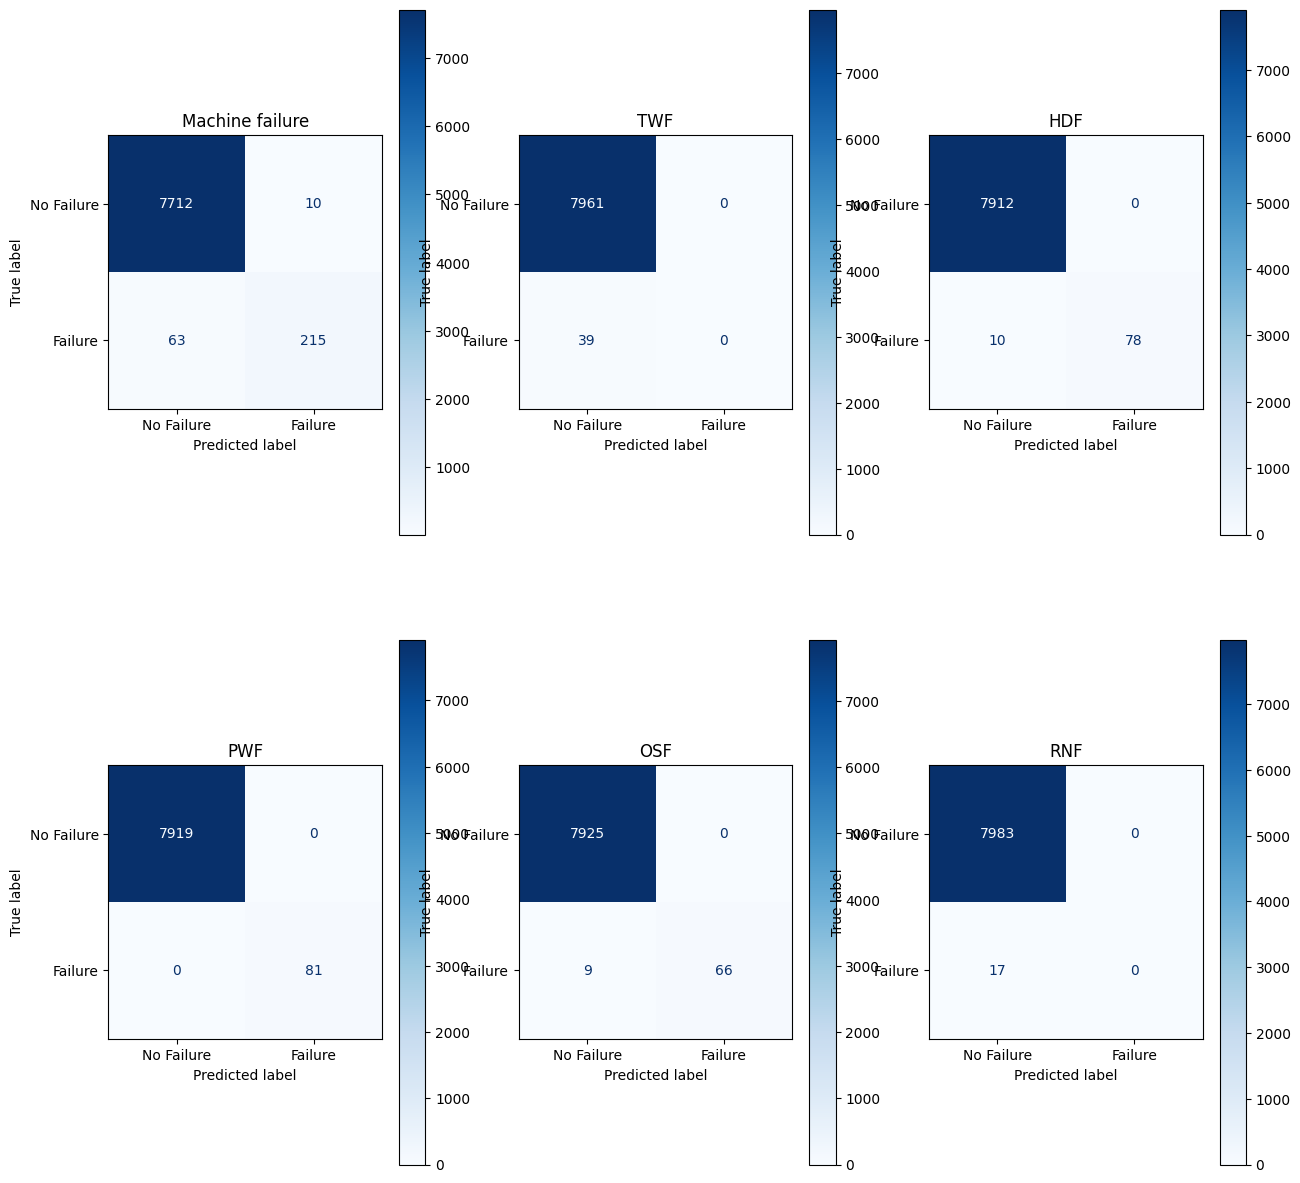

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
#y_pred=best_clf.predict(X_train_reduced)
#y_pred = pd.DataFrame(y_pred, columns=y_train.columns)

y_probs = best_clf.predict_proba(X_train_reduced)
# Custom thresholds (e.g., [0.4, 0.4, 0.5])
thresholds = [0.5,0.4, 0.5,0.5,0.5,0.5]
custom_preds = np.column_stack([
    (y_probs[i][:, 1] > thresholds[i]).astype(int) for i in range(y_train.shape[1])
])
y_pred = pd.DataFrame(custom_preds, columns=y_train.columns)

no_of_label = len(y_pred.columns)
i = 0
no_of_column = 3
left_over = no_of_label % no_of_column
no_of_row = no_of_label // no_of_column+left_over
plt.figure(figsize=(15,15))
for label in y_pred.columns:
    i +=1
    ax=plt.subplot(no_of_row, no_of_column, i)
    cm = confusion_matrix(y_train[label],y_pred[label])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Failure', 'Failure'])
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title(label=label)
plt.show()

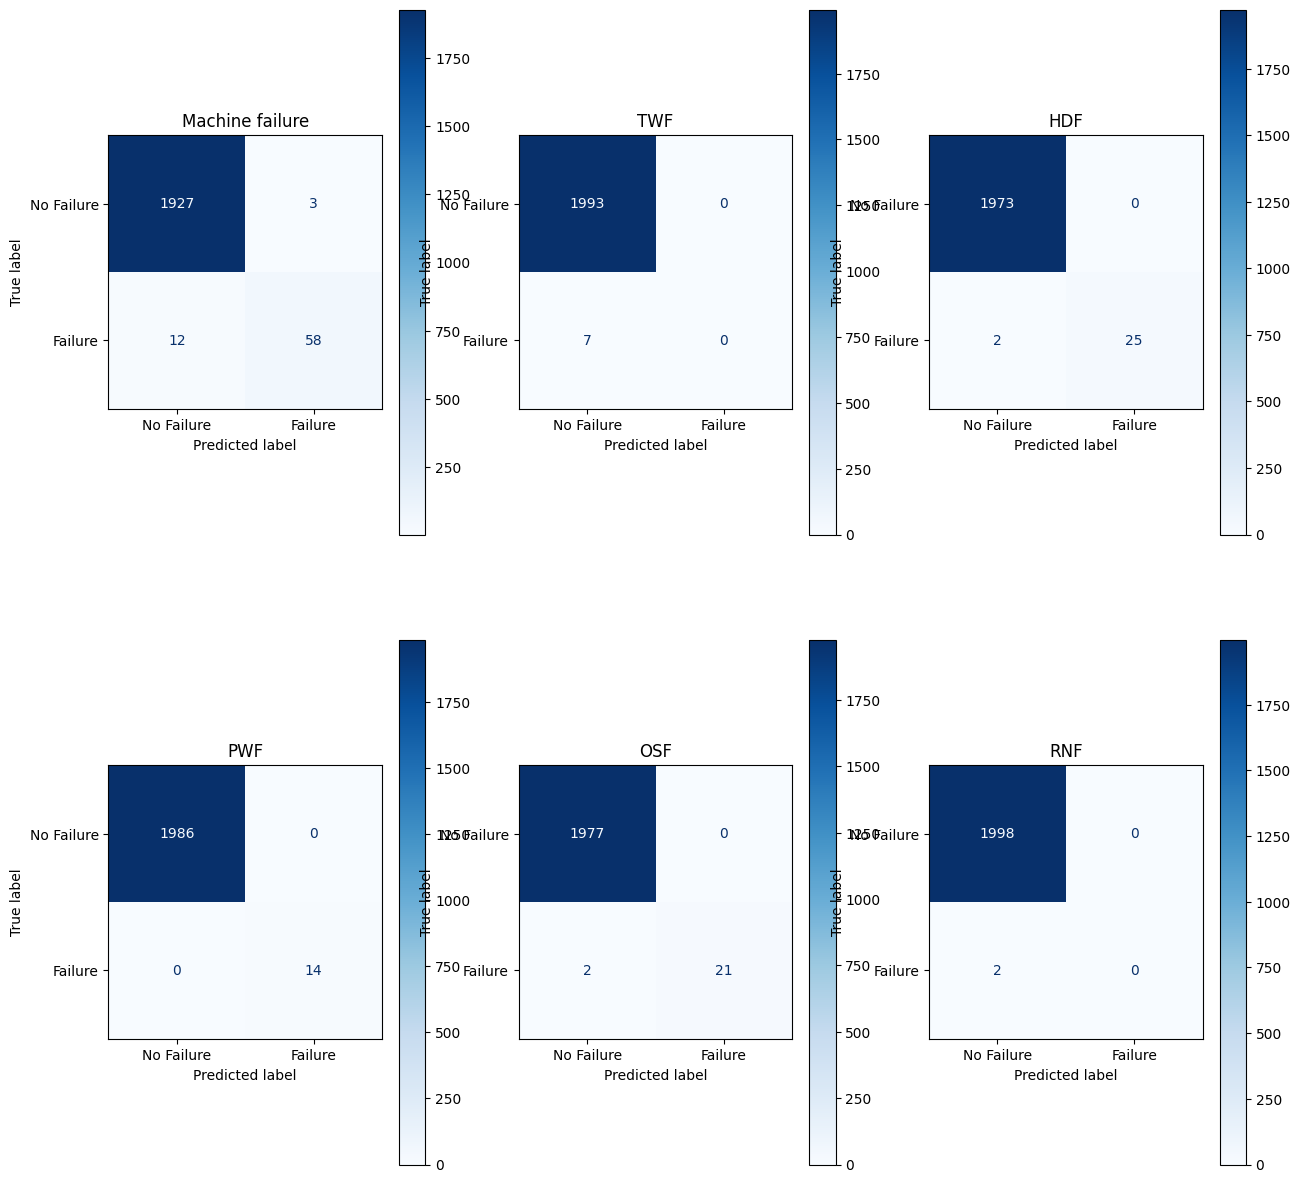

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
# y_pred=best_clf.predict(X_test_reduced)
y_pred = pd.DataFrame(y_pred, columns=y_test.columns)

y_probs = best_clf.predict_proba(X_test_reduced)
# Custom thresholds (e.g., [0.4, 0.4, 0.5])
thresholds = [0.5,0.4, 0.5,0.5,0.5,0.5]
custom_preds = np.column_stack([
    (y_probs[i][:, 1] > thresholds[i]).astype(int) for i in range(y_test.shape[1])
])
y_pred = pd.DataFrame(custom_preds, columns=y_test.columns)

# y_pred = pd.DataFrame(y_pred, columns=y_test.columns)

no_of_label = len(y_pred.columns)
i = 0
no_of_column = 3
left_over = no_of_label % no_of_column
no_of_row = no_of_label // no_of_column+left_over
plt.figure(figsize=(15,15))
for label in y_pred.columns:
    i +=1
    ax=plt.subplot(no_of_row, no_of_column, i)
    cm = confusion_matrix(y_test[label],y_pred[label])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Failure', 'Failure'])
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title(label=label)
plt.show()

Adjusting threshold for TWF does help us to reducd False Negative but at the cost of huge increase in False Positive.

We need to explore a better way to train our predictor

### Save Best Classifier/Predictor

In [11]:
import pickle
with open('ml_predictor.pkl', 'wb') as f:
    pickle.dump(best_clf, f)
print("Best ML Predictor model saved to 'ml_predictor.pkl'")

Best ML Predictor model saved to 'ml_predictor.pkl'


## Conclusion

Our Decision Tree classifier is simple and yet perform sufficiently for our need as it matches XGBoost performance